In [2]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader  # Use PyTorch Geometric's DataLoader
import torch
import matplotlib.pyplot as plt
from shared.utils import calculate_accuracy
from shared.training import train_classifier
from torch_geometric.nn import summary, GraphConv
torch.manual_seed(1234)

dataset = TUDataset(root='/tmp/ENZYMES', name='MUTAG')
print(
    "Num of data points: ",len(dataset),
    ", each with ",dataset.num_node_features," features.\n",sep=""
    )

classes, nums = torch.unique(dataset.y, return_counts=True)

for cls, n in zip(classes, nums):
    print(f'Class {cls.item()}: {n.item()}')

print("naive guessing accuracy: ", max(nums.float()) / sum(nums.float()))

Num of data points: 188, each with 7 features.

Class 0: 63
Class 1: 125
naive guessing accuracy:  tensor(0.6649)


In [3]:
from shared.models import GNNClassifier

model = GNNClassifier(dataset=dataset, hidden_ch=64, dropout=0.2, message_passing_module=GraphConv)
print(summary(model, x=dataset[0].x, edge_index=dataset[0].edge_index, batch=None))

+----------------------------+-------------------+----------------+----------+
| Layer                      | Input Shape       | Output Shape   | #Param   |
|----------------------------+-------------------+----------------+----------|
| GNNClassifier              |                   | [1, 64]        | 21,632   |
| ├─(convolutions)ModuleList | --                | --             | 17,472   |
| │    └─(0)GraphConv        | [17, 7], [2, 38]  | [17, 64]       | 960      |
| │    └─(1)GraphConv        | [17, 64], [2, 38] | [17, 64]       | 8,256    |
| │    └─(2)GraphConv        | [17, 64], [2, 38] | [17, 64]       | 8,256    |
| ├─(lin_layers)ModuleList   | --                | --             | 4,160    |
| │    └─(0)Linear           | [1, 64]           | [1, 64]        | 4,160    |
+----------------------------+-------------------+----------------+----------+


In [4]:
dataset = dataset.shuffle()
N = len(dataset)
train_dataset = dataset[:int(0.6 * N)]
val_dataset = dataset[int(0.6 * N):int(0.8 * N)]
test_dataset = dataset[int(0.8 * N):]

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 112
Validation dataset size: 38
Test dataset size: 38


Epoch    T Loss  T Acc  V Loss  V Acc

1/50     2.519   0.406   1.463   0.842
2/50     1.391   0.625   1.131   0.711
3/50     1.394   0.609   1.146   0.789
4/50     1.624   0.617   1.474   0.711
5/50     1.690   0.586   0.998   0.816
6/50     1.537   0.656   0.940   0.789
7/50     1.324   0.719   1.202   0.789
8/50     1.351   0.656   1.272   0.763
9/50     1.421   0.680   0.938   0.789
10/50    1.476   0.617   1.034   0.789
11/50    1.547   0.656   1.077   0.763
12/50    1.277   0.664   0.855   0.789
13/50    1.536   0.695   1.196   0.816
14/50    1.464   0.664   1.108   0.789
15/50    1.178   0.742   0.731   0.763
16/50    1.063   0.758   0.869   0.816
17/50    1.271   0.695   0.934   0.816
18/50    1.564   0.602   0.924   0.763
19/50    1.367   0.633   0.819   0.763
20/50    1.428   0.688   0.999   0.789
21/50    1.326   0.711   0.941   0.711
22/50    1.140   0.727   0.621   0.789
23/50    1.483   0.695   1.127   0.763
24/50    1.271   0.711   1.045   0.789
25/50    1.147   0.734   

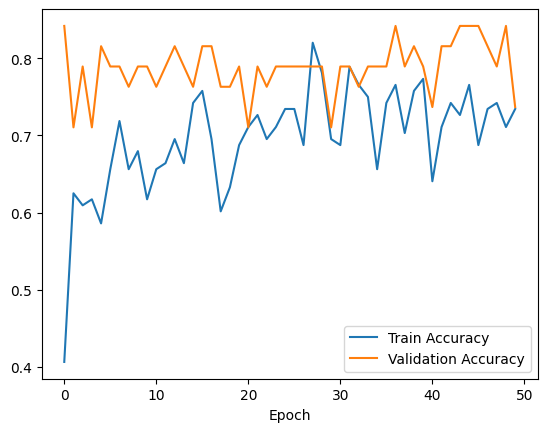

In [5]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Reduced learning rate

train_accs, val_accs = train_classifier(
    N_epochs=50,
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss=loss,
)
    
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()

In [6]:
for batch in test_dataloader:
    model.eval()
    with torch.no_grad():
        out = model(batch.x, batch.edge_index, batch.batch)
        test_acc = calculate_accuracy(out, batch.y)
        print(f'Test Accuracy: {test_acc:.4f}\n')
        out = torch.argmax(out, dim=1)
        y = batch.y
        correct = torch.where(out == y, 1, 0)
        print(torch.sum(correct).item(), "correct predictions out of", len(correct))
        print("pred, true, correct?")
        print(*zip(out.tolist(), y.tolist(), correct.tolist()), sep='\n')

Test Accuracy: 0.7368

28 correct predictions out of 38
pred, true, correct?
(0, 1, 0)
(1, 1, 1)
(0, 1, 0)
(1, 1, 1)
(0, 1, 0)
(0, 0, 1)
(1, 1, 1)
(0, 0, 1)
(0, 1, 0)
(0, 0, 1)
(0, 1, 0)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(0, 0, 1)
(0, 0, 1)
(1, 1, 1)
(0, 1, 0)
(1, 1, 1)
(0, 1, 0)
(1, 1, 1)
(0, 0, 1)
(0, 1, 0)
(0, 1, 0)
(1, 1, 1)
(0, 0, 1)
(0, 0, 1)
(1, 1, 1)
(0, 0, 1)
(1, 1, 1)
(0, 0, 1)
(0, 0, 1)
(0, 0, 1)
(1, 1, 1)
(0, 1, 0)
(0, 0, 1)
(1, 1, 1)
(1, 1, 1)
